In [1]:
#Import some modules
import numpy as np
import pandas as pd
from scipy import interp
%matplotlib inline
import matplotlib.pyplot as plt
import model_fitting as mfit
import loan_roi as lr

from sklearn.feature_selection import f_regression, SelectKBest, f_classif
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier

In [2]:
#Read in the training, test, and validation data sets
X_train = pd.read_pickle('X_train')
y_train = pd.read_pickle('y_train')
X_test = pd.read_pickle('X_test')
y_test = pd.read_pickle('y_test')
X_val = pd.read_pickle('X_val')
y_val = pd.read_pickle('y_val')
ROI = pd.read_pickle('ROI')

In [3]:
#Get the list of reliable features
reliable_feat = mfit.get_reliable_features(X_train, y_train)

In [3]:
#Get reliable features without loan amount and interest rate
reliable_feat_no_amnt_intr = mfit.get_reliable_features(X_train.drop(['int_rate', 'loan_amnt'], axis = 1), 
                                                        y_train)

In [4]:
cv = StratifiedKFold(y_train, n_folds=5, shuffle=True, random_state=42)

In [13]:
#Train Naive Bayes classifier, one feature at at time, in order of importance, significant features only
#Performance deteriorates after about twenty features, only train on those twenty
NB_clf = GaussianNB()

NB_feat_df = mfit.add_feature_auc(X_train, y_train, X_val, y_val, NB_clf, cv, 44)
NB_feat_df

,cv_auc,cv_std,train_auc,val_auc
1,0.675513,0.003280,0.675547,0.671889
2,0.681346,0.002145,0.681421,0.678705
3,0.675575,0.002265,0.675647,0.672104
4,0.675659,0.002861,0.675767,0.673606
5,0.673597,0.003007,0.673673,0.672332
6,0.674850,0.003426,0.676686,0.674615
7,0.677187,0.003328,0.679105,0.677364
8,0.677209,0.003299,0.679125,0.677499
9,0.676410,0.003051,0.678467,0.677938
10,0.676087,0.002835,0.677905,0.680038


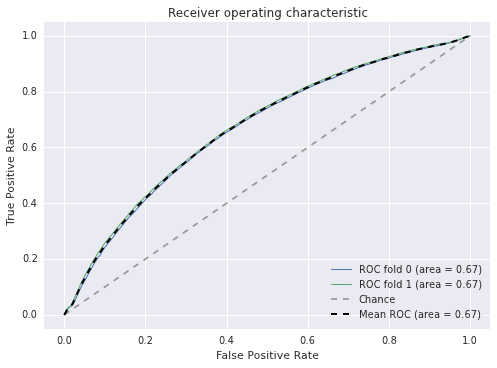

In [18]:
#Train Naive Bayes on 20 most reliable features and plot ROC
#Training AUC is 0.67
_, NB_clf = mfit.fit_plot_ROC(X_train[reliable_feat.index[0:19]], y_train, NB_clf, cv)

/Users/jared/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


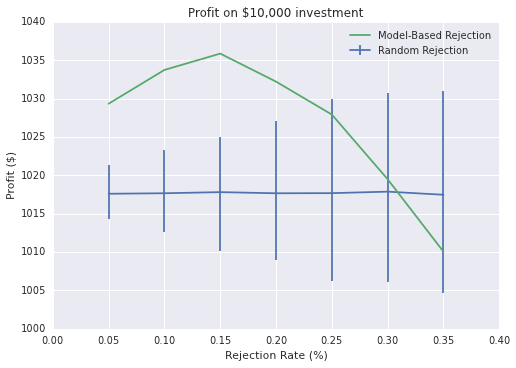

In [19]:
#Look at performance in monetary terms for validation set
probas_ = NB_clf.predict_proba(X_val[reliable_feat.index[0:19]])
prob_default = pd.Series(data = probas_[:,1], index=X_val[reliable_feat.index[0:19]].index)
pred_ROI = ROI.loc[X_val[reliable_feat.index[0:19]].index]
pred_ROI['default'] = y_val
b = 10000
p_rej = np.arange(0.05, 0.4, 0.05)
val_frame = lr.model_perf_dollars(pred_ROI, prob_default, p_rej, 'default', 'roi', 0)

In [23]:
val_frame

,reject,random,random_hi_ci,random_lo_ci,perfect
0.05,1026.957432,1017.623532,1021.346667,1014.446094,1245.888302
0.10,1033.527778,1017.537733,1023.280448,1012.017968,1245.888302
0.15,1035.289048,1017.686160,1024.475781,1011.300325,1245.888302
0.20,1030.742857,1017.611091,1027.051163,1008.923835,1245.888302
0.25,1023.178863,1017.611563,1028.959776,1006.244986,1245.888302
0.30,1015.357756,1017.893935,1029.864644,1006.010551,1245.888302
0.35,1003.540000,1017.787825,1031.616667,1004.587802,1245.888302


In [28]:
#Test adding features one at a time for Naive Bayes without including the interest rate or loan amount
#Performance peaks at around 20 features
NB_feat_df = mfit.add_feature_auc(X_train.drop(['int_rate', 'loan_amnt'], axis = 1),
                                  y_train, X_val.drop(['int_rate', 'loan_amnt'], axis = 1), y_val, NB_clf, cv, 44)
NB_feat_df

,cv_auc,cv_std,train_auc,val_auc
1,0.581662,0.003670,0.581645,0.580203
2,0.600759,0.003552,0.600827,0.598338
3,0.609814,0.002467,0.609913,0.610047
4,0.612405,0.002302,0.615079,0.614422
5,0.616374,0.002435,0.618963,0.618710
6,0.614606,0.002009,0.616944,0.616313
7,0.614414,0.002738,0.616656,0.616955
8,0.618085,0.002807,0.620035,0.623412
9,0.619788,0.002678,0.621728,0.624181
10,0.619862,0.002599,0.621826,0.623101


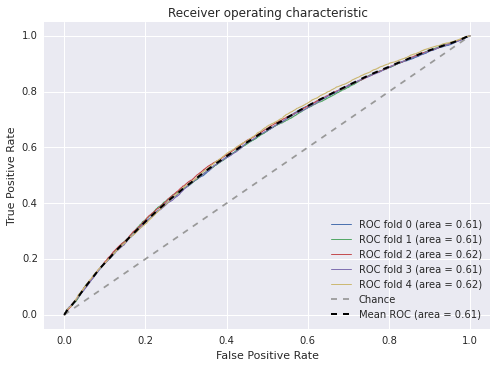

In [29]:
#Train Naive Bayes on 20 most reliable features (exclude interest and loan amount) and plot ROC
#Training AUC is 0.61
_, NB_clf = mfit.fit_plot_ROC(X_train[reliable_feat_no_amnt_intr.index[0:19]], y_train, NB_clf, cv)

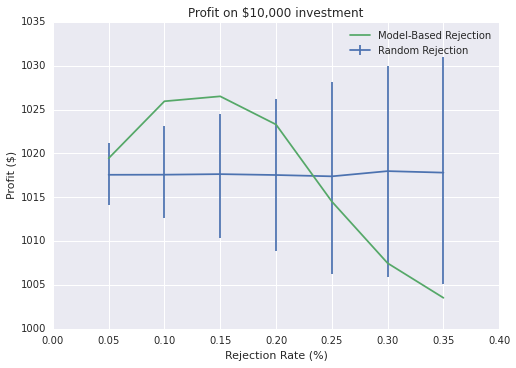

In [30]:
#Look at performance in monetary terms for validation set, excluding interest and loan amount
probas_ = NB_clf.predict_proba(X_val[reliable_feat_no_amnt_intr.index[0:19]])
prob_default = pd.Series(data = probas_[:,1], index=X_val[reliable_feat_no_amnt_intr.index[0:19]].index)
pred_ROI = ROI.loc[X_val[reliable_feat_no_amnt_intr.index[0:19]].index]
pred_ROI['default'] = y_val
b = 10000
p_rej = np.arange(0.05, 0.4, 0.05)
val_frame = lr.model_perf_dollars(pred_ROI, prob_default, p_rej, 'default', 'roi', 0)

In [31]:
val_frame

,reject,random,random_hi_ci,random_lo_ci,perfect
0.05,1019.445417,1017.564015,1021.237127,1014.123385,1245.888302
0.10,1025.950000,1017.575805,1023.166972,1012.620690,1245.888302
0.15,1026.511861,1017.639678,1024.476531,1010.393923,1245.888302
0.20,1023.297937,1017.538725,1026.252925,1008.924446,1245.888302
0.25,1014.517857,1017.387673,1028.192620,1006.245000,1245.888302
0.30,1007.483333,1017.982954,1029.990321,1005.914211,1245.888302
0.35,1003.533333,1017.810222,1031.020966,1005.132539,1245.888302


For the Naive Bayes classifier, I tested performance out to 44 features in order of reliability. Including the first 20 features alone led to peak performance. For this classifier, the area under the ROC curve is 0.67. If this classifier is used to reject the top 15% of loans with respect to riskiness, the return on a \$10,000 investment would be \$1035.29. This return reliable is above the chance return, calculated by randomly dropping 15 percent of the loans (bootstrapping analysis). It is important to note that perfect rejection (i.e., only loans that default) would yield a return of \$1245.88. This value represents the best possible performance. 

One caveat is that I have included interest rate and loan amount. The interest rate is directly assigned by the Lending Club using their in-house risk metrics and the loan amount may be as well. When these values are excluded, the area under the ROC curve drops to 0.61. In monetary terms, the return on a \$10,000 investment would be \$1026.51 if the top 15 percent of risky loans are rejected. This is still better performance than chance

In [32]:
#Train Logistic Regression classifier, one feature at at time, in order of importance, significant features only
#Performance increases as the number of features increases, use all 44
LR_clf = LogisticRegression(penalty='l2', C=1, class_weight = {0: (1.0 - 0.1841), 1: 0.1841})
LR_feat_df = mfit.add_feature_auc(X_train, y_train, X_val, y_val, LR_clf, cv, 44)
LR_feat_df

,cv_auc,cv_std,train_auc,val_auc
1,0.675513,0.003280,0.675547,0.671889
2,0.682182,0.002367,0.682294,0.678927
3,0.682157,0.002368,0.682224,0.678648
4,0.682911,0.002512,0.683002,0.679916
5,0.682921,0.002515,0.683010,0.679934
6,0.692820,0.002803,0.692901,0.691771
7,0.693241,0.002978,0.693362,0.692659
8,0.693344,0.003033,0.693435,0.692797
9,0.693304,0.002948,0.693433,0.692688
10,0.695123,0.002774,0.695200,0.695473


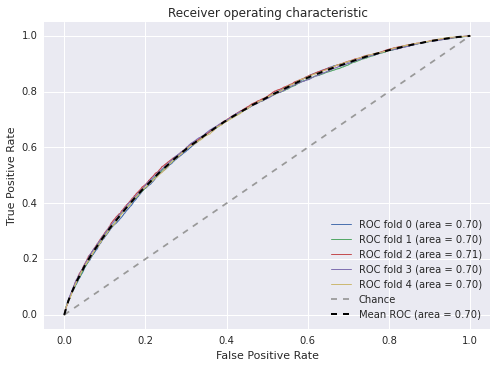

In [33]:
#Train Logistic Regression on 44 most reliable features and plot ROC
#Training AUC is 0.70
_, LR_clf = mfit.fit_plot_ROC(X_train[reliable_feat.index[0:43]], y_train, LR_clf, cv)


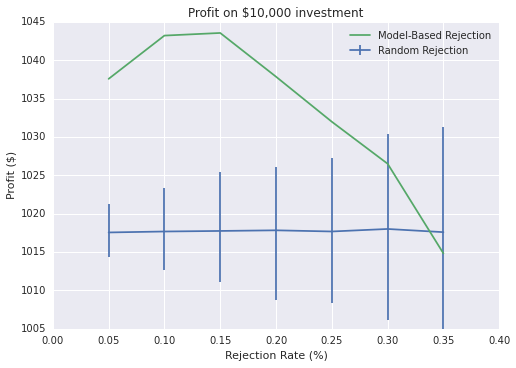

In [34]:
#Look at performance in monetary terms for validation set
probas_ = LR_clf.predict_proba(X_val[reliable_feat.index[0:43]])
prob_default = pd.Series(data = probas_[:,1], index=X_val[reliable_feat.index[0:43]].index)
pred_ROI = ROI.loc[X_val[reliable_feat.index[0:43]].index]
pred_ROI['default'] = y_val
b = 10000
p_rej = np.arange(0.05, 0.4, 0.05)
val_frame = lr.model_perf_dollars(pred_ROI, prob_default, p_rej, 'default', 'roi', 0)

In [35]:
val_frame

,reject,random,random_hi_ci,random_lo_ci,perfect
0.05,1037.574521,1017.557265,1021.308627,1014.326406,1245.888302
0.10,1043.216667,1017.682241,1023.297937,1012.620172,1245.888302
0.15,1043.557408,1017.753758,1025.425292,1011.057234,1245.888302
0.20,1037.857143,1017.836473,1026.103571,1008.720804,1245.888302
0.25,1031.986441,1017.683580,1027.300000,1008.343169,1245.888302
0.30,1026.511861,1018.011131,1030.431010,1006.096312,1245.888302
0.35,1014.826087,1017.595803,1031.296970,1005.021945,1245.888302


In [36]:
#Test adding features one at a time for Logistic Regression without including the interest rate or loan amount
#Performance continues increasing as features are added
LR_feat_df = mfit.add_feature_auc(X_train.drop(['int_rate', 'loan_amnt'], axis = 1),
                                  y_train, X_val.drop(['int_rate', 'loan_amnt'], axis = 1), y_val, LR_clf, cv, 44)
LR_feat_df

,cv_auc,cv_std,train_auc,val_auc
1,0.581662,0.003670,0.581645,0.580203
2,0.600679,0.003975,0.600725,0.597512
3,0.612185,0.002446,0.612277,0.612407
4,0.625552,0.002181,0.625647,0.627787
5,0.627120,0.002305,0.627196,0.629034
6,0.627246,0.002241,0.627339,0.628929
7,0.627545,0.002511,0.627605,0.628697
8,0.632413,0.002507,0.632526,0.636154
9,0.636515,0.002276,0.636633,0.639030
10,0.637575,0.001709,0.637788,0.639382


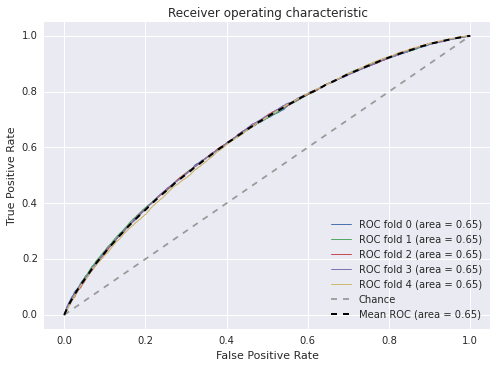

In [37]:
#Train Logistic Regression on 44 most reliable features (exclude interest and loan amount) and plot ROC
#Training AUC is 0.65
_, LR_clf = mfit.fit_plot_ROC(X_train[reliable_feat_no_amnt_intr.index[0:43]], y_train, LR_clf, cv)

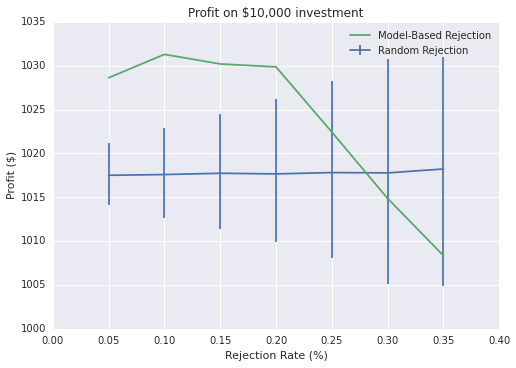

In [38]:
#Look at performance in monetary terms for validation set, excluding interest and loan amount
probas_ = LR_clf.predict_proba(X_val[reliable_feat_no_amnt_intr.index[0:43]])
prob_default = pd.Series(data = probas_[:,1], index=X_val[reliable_feat_no_amnt_intr.index[0:43]].index)
pred_ROI = ROI.loc[X_val[reliable_feat_no_amnt_intr.index[0:43]].index]
pred_ROI['default'] = y_val
b = 10000
p_rej = np.arange(0.05, 0.4, 0.05)
val_frame = lr.model_perf_dollars(pred_ROI, prob_default, p_rej, 'default', 'roi', 0)

In [39]:
val_frame

,reject,random,random_hi_ci,random_lo_ci,perfect
0.05,1028.628689,1017.509585,1021.237127,1014.123385,1245.888302
0.10,1031.296970,1017.591380,1022.882502,1012.600000,1245.888302
0.15,1030.204966,1017.738223,1024.476531,1011.354167,1245.888302
0.20,1029.866669,1017.665061,1026.257885,1009.899924,1245.888302
0.25,1022.437143,1017.815073,1028.316434,1008.102632,1245.888302
0.30,1014.865424,1017.779350,1030.741109,1005.160772,1245.888302
0.35,1008.348214,1018.226637,1030.991429,1004.906884,1245.888302


For the Logistic Regression classifier, I tested performance out to 44 features in order of reliability. Including the all features led to peak performance. For this classifier, the area under the ROC curve is 0.70. If this classifier is used to reject the top 15% of loans with respect to riskiness, the return on a \$10,000 investment would be \$1043.55. This return reliable is above the chance return. Perfect rejection (i.e., only loans that default) would yield a return of \$1245.88. 

Excluding the interest rate and loan amount, the area under the ROC curve drops to 0.649. In monetary terms, the return on a \$10,000 investment would be \$1030.20 if the top 15 percent of risky loans are rejected. This is still better performance than chance

In [45]:
#Train Decision Tree Classifier, one feature at a time, testing different max depths
#max_depth = 3, AUC = 0.67; max_depth = 6, AUC = 0.73; max_depth = 12, AUC = 0.73;
#Decision Tree starts overfitting after 6 layers, no signs of overfitting at 6
#Performance starts to deteriorate a bit after 25 features
DT_clf = DecisionTreeClassifier(max_depth = 6, min_samples_leaf = 5, class_weight = {0: (1.0 - 0.1841), 1: 0.1841})
DT_feat_df = mfit.add_feature_auc(X_train, y_train, X_val, y_val, DT_clf, cv, 44)
DT_feat_df

,cv_auc,cv_std,train_auc,val_auc
1,0.676051,0.003803,0.678184,0.672558
2,0.680380,0.002578,0.685100,0.677378
3,0.680047,0.002852,0.685418,0.676921
4,0.680333,0.002886,0.685369,0.676911
5,0.680465,0.003376,0.685803,0.676825
6,0.685747,0.002133,0.694674,0.684457
7,0.685691,0.002214,0.694674,0.684457
8,0.685851,0.002204,0.694504,0.684421
9,0.685679,0.002381,0.694523,0.684495
10,0.685796,0.002537,0.693692,0.684477


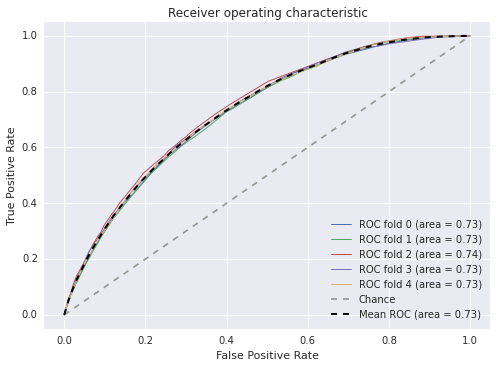

In [46]:
#Train Decision Tree on 25 most reliable features and plot ROC
#Training AUC is 0.73
_, DT_clf = mfit.fit_plot_ROC(X_train[reliable_feat.index[0:24]], y_train, DT_clf, cv)

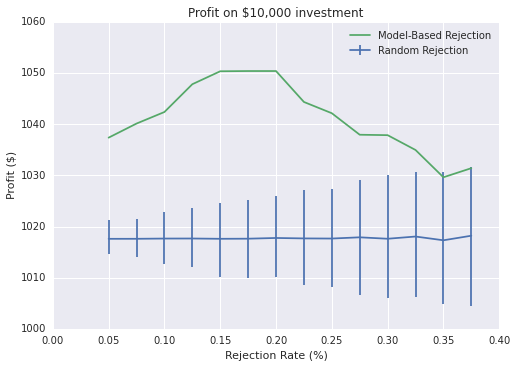

In [49]:
#Look at performance in monetary terms for validation set
probas_ = DT_clf.predict_proba(X_val[reliable_feat.index[0:24]])
prob_default = pd.Series(data = probas_[:,1], index=X_val[reliable_feat.index[0:24]].index)
pred_ROI = ROI.loc[X_val[reliable_feat.index[0:24]].index]
pred_ROI['default'] = y_val
b = 10000
p_rej = np.arange(0.05, 0.4, 0.025)
val_frame = lr.model_perf_dollars(pred_ROI, prob_default, p_rej, 'default', 'roi', 0)

In [50]:
val_frame

,reject,random,random_hi_ci,random_lo_ci,perfect
0.050,1037.369181,1017.591036,1021.346667,1014.581197,1245.888302
0.075,1040.125000,1017.596665,1021.423229,1014.019048,1245.888302
0.100,1042.385000,1017.643802,1022.833808,1012.620690,1245.888302
0.125,1047.816906,1017.653066,1023.625375,1012.051187,1245.888302
0.150,1050.349511,1017.596160,1024.500000,1010.057875,1245.888302
0.175,1050.393510,1017.618287,1025.147407,1009.975000,1245.888302
0.200,1050.393510,1017.756579,1025.950000,1010.113873,1245.888302
0.225,1044.346570,1017.670008,1027.214286,1008.566667,1245.888302
0.250,1042.143660,1017.645466,1027.403255,1008.125825,1245.888302
0.275,1037.941729,1017.886589,1029.009065,1006.603066,1245.888302


In [53]:
#Test adding features one at a time for Decision Tree without including the interest rate or loan amount
#max_depth = 3, AUC = 0.62; max_depth = 6, AUC = 0.68; max_depth = 12, AUC = 0.68;
#Tree clearly overfits after 6 layers
#Performance deteriorates after 10 features
DT_clf = DecisionTreeClassifier(max_depth = 6, min_samples_leaf = 5, class_weight = {0: (1.0 - 0.1841), 1: 0.1841})
DT_feat_df = mfit.add_feature_auc(X_train.drop(['int_rate', 'loan_amnt'], axis = 1),
                                  y_train, X_val.drop(['int_rate', 'loan_amnt'], axis = 1), y_val, DT_clf, cv, 44)
DT_feat_df

,cv_auc,cv_std,train_auc,val_auc
1,0.577857,0.003996,0.584343,0.578099
2,0.596331,0.002791,0.606136,0.596138
3,0.606769,0.001637,0.615123,0.610216
4,0.615591,0.001044,0.626323,0.617612
5,0.615596,0.001278,0.626594,0.617324
6,0.615759,0.001354,0.626792,0.617566
7,0.616567,0.001946,0.627793,0.618654
8,0.617821,0.001530,0.628465,0.621653
9,0.681365,0.005328,0.687365,0.680824
10,0.681340,0.005319,0.687363,0.680840


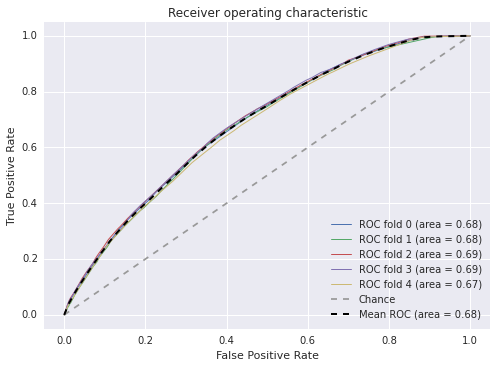

In [54]:
#Train Decision Tree on 10 most reliable features (exclude interest and loan amount) and plot ROC
#Training AUC is 0.68
_, DT_clf = mfit.fit_plot_ROC(X_train[reliable_feat_no_amnt_intr.index[0:9]], y_train, DT_clf, cv)

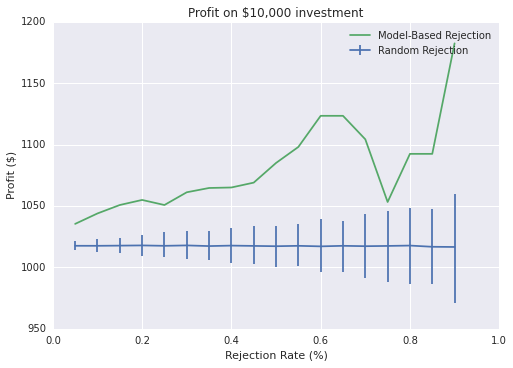

In [57]:
#Look at performance in monetary terms for validation set, excluding interest and loan amount
probas_ = DT_clf.predict_proba(X_val[reliable_feat_no_amnt_intr.index[0:9]])
prob_default = pd.Series(data = probas_[:,1], index=X_val[reliable_feat_no_amnt_intr.index[0:9]].index)
pred_ROI = ROI.loc[X_val[reliable_feat_no_amnt_intr.index[0:9]].index]
pred_ROI['default'] = y_val
b = 10000
p_rej = np.arange(0.05, 0.95, 0.05)
val_frame = lr.model_perf_dollars(pred_ROI, prob_default, p_rej, 'default', 'roi', 0)

In [58]:
val_frame

,reject,random,random_hi_ci,random_lo_ci,perfect
0.05,1035.461538,1017.624923,1021.272490,1014.517857,1245.888302
0.10,1043.961953,1017.608082,1023.172765,1012.383029,1245.888302
0.15,1050.842857,1017.756325,1024.092637,1011.358333,1245.888302
0.20,1054.965877,1017.924660,1026.726012,1009.042816,1245.888302
0.25,1050.842857,1017.593859,1029.120000,1008.105263,1245.888302
0.30,1061.210000,1017.932159,1030.015226,1006.959828,1245.888302
0.35,1064.712843,1017.389033,1029.981233,1006.129783,1245.888302
0.40,1065.114130,1017.775766,1031.986780,1003.488658,1245.888302
0.45,1069.073333,1017.525764,1033.366667,1003.019245,1245.888302
0.50,1085.084615,1017.269685,1033.530025,1000.313924,1245.888302


For the Decision Tree classifier, I tested performance out to 44 features in order of reliability for maximum tree depths of 3, 6, and 12. After a depth of 6, the performance is flat and the trees begin to overfit. Including 25 features led to peak performance. For this classifier, the area under the ROC curve is 0.73. If this classifier is used to reject the top 15% of loans with respect to riskiness, the return on a \$10,000 investment would be $1050.84. This return reliable is above the chance return. If 20% of loans are rejected, then a return of \$1054.96 is possible. Perfect rejection (i.e., only loans that default) would yield a return of \$1245.88. 

Excluding the interest rate and loan amount, the area under the ROC curve drops to 0.68. In monetary terms, the return on a \$10,000 investment would be $1050.84 if the top 15 percent of risky loans are rejected. This is still better performance than chance. Performance does increase as rejection rates increase to a peak at 60% rejection with a return of \$1123.49. Performance rises again after a rejection rate of 75 percent, but such high rejection rates are quite unreasonable. Note that this is performance on the validation set. Performance on the test set remains to be seen. 

In [9]:
#Test adding features one at a time for Random Forest
#n_estimators = 10, AUC = 0.72, peaks at 12 features, 0.95 training AUC
#n_estimators = 25, AUC = 0.74, peaks at 19 features, 0.97 training AUC
#n_estimators = 50, AUC = 0.74, peaks at 25 features, 0.98 training AUC
RF_clf = RandomForestClassifier(n_estimators=25, min_samples_leaf = 5, class_weight = {0: (1.0 - 0.1841), 1: 0.1841})
RF_feat_df = mfit.add_feature_auc(X_train, y_train, X_val, y_val, RF_clf, cv, 44)

RF_feat_df

,cv_auc,cv_std,train_auc,val_auc
1,0.676248,0.003377,0.683703,0.671632
2,0.638837,0.002041,0.864766,0.637442
3,0.650852,0.002176,0.921356,0.650044
4,0.650881,0.003007,0.935578,0.656058
5,0.657002,0.003188,0.946710,0.662013
6,0.674611,0.003195,0.951678,0.674975
7,0.677580,0.002568,0.949635,0.680674
8,0.677059,0.003753,0.946078,0.680559
9,0.678954,0.003134,0.957595,0.684437
10,0.681900,0.002504,0.955757,0.687607


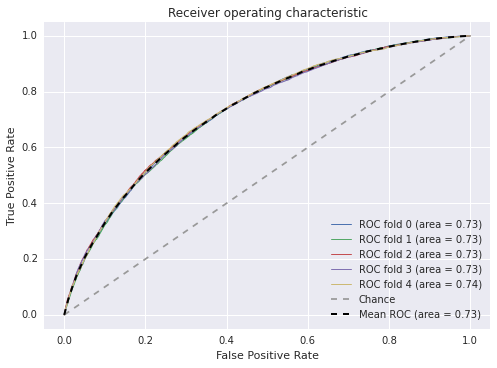

In [10]:
#Train Random Forest on 19 most reliable features and plot ROC
#Training AUC is 0.73
_, RF_clf = mfit.fit_plot_ROC(X_train[reliable_feat.index[0:18]], y_train, RF_clf, cv)

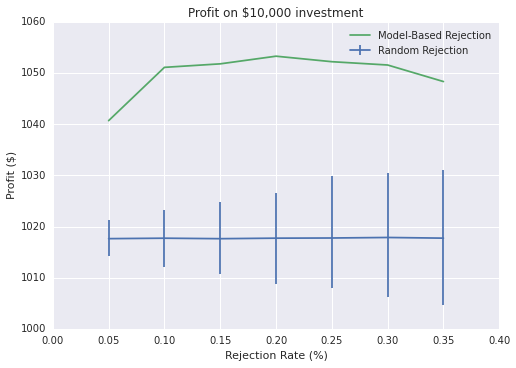

In [11]:
#Look at performance in monetary terms for validation set
probas_ = RF_clf.predict_proba(X_val[reliable_feat.index[0:18]])
prob_default = pd.Series(data = probas_[:,1], index=X_val[reliable_feat.index[0:18]].index)
pred_ROI = ROI.loc[X_val[reliable_feat.index[0:18]].index]
pred_ROI['default'] = y_val
b = 10000
p_rej = np.arange(0.05, 0.4, 0.05)
val_frame = lr.model_perf_dollars(pred_ROI, prob_default, p_rej, 'default', 'roi', 0)

In [12]:
val_frame

,reject,random,random_hi_ci,random_lo_ci,perfect
0.05,1040.692313,1017.624095,1021.308627,1014.326406,1245.888302
0.10,1051.112500,1017.712423,1023.181840,1012.017968,1245.888302
0.15,1051.799135,1017.617637,1024.733486,1010.748558,1245.888302
0.20,1053.295532,1017.719162,1026.595208,1008.819444,1245.888302
0.25,1052.218645,1017.751463,1029.958333,1008.000000,1245.888302
0.30,1051.572816,1017.853063,1030.475370,1006.228506,1245.888302
0.35,1048.337696,1017.723644,1030.991990,1004.587802,1245.888302


In [13]:
#Test adding features one at a time for Random Forest without including the interest rate or loan amount
#Peaks at 17 features
RF_clf = RandomForestClassifier(n_estimators=25, min_samples_leaf = 5, class_weight = {0: (1.0 - 0.1841), 1: 0.1841})
RF_feat_df = mfit.add_feature_auc(X_train.drop(['int_rate', 'loan_amnt'], axis = 1),
                                  y_train, X_val.drop(['int_rate', 'loan_amnt'], axis = 1), y_val, RF_clf, cv, 42)
RF_feat_df

,cv_auc,cv_std,train_auc,val_auc
1,0.541010,0.001032,0.625722,0.553926
2,0.551784,0.002290,0.898561,0.553785
3,0.565768,0.004617,0.906463,0.564916
4,0.592780,0.002866,0.944554,0.588296
5,0.595028,0.002165,0.943602,0.593784
6,0.595149,0.002417,0.939452,0.594752
7,0.608321,0.002072,0.949829,0.604420
8,0.612931,0.001226,0.944623,0.613765
9,0.687219,0.001524,0.953642,0.689937
10,0.687459,0.001663,0.961987,0.691884


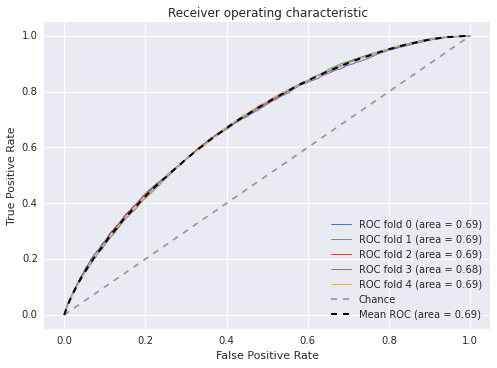

In [14]:
#Train Random Forest on 17 most reliable features (exclude interest and loan amount) and plot ROC
#Training AUC is 0.69
_, RF_clf = mfit.fit_plot_ROC(X_train[reliable_feat_no_amnt_intr.index[0:16]], y_train, RF_clf, cv)

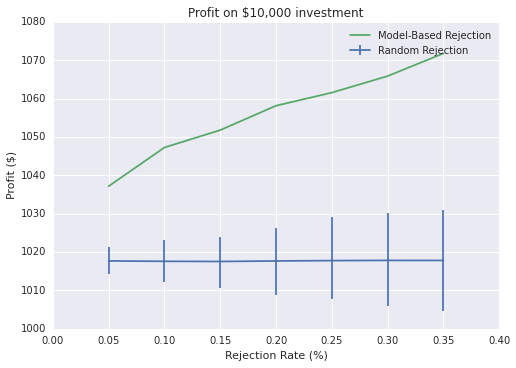

In [15]:
#Look at performance in monetary terms for validation set, excluding interest and loan amount
probas_ = RF_clf.predict_proba(X_val[reliable_feat_no_amnt_intr.index[0:16]])
prob_default = pd.Series(data = probas_[:,1], index=X_val[reliable_feat_no_amnt_intr.index[0:16]].index)
pred_ROI = ROI.loc[X_val[reliable_feat_no_amnt_intr.index[0:16]].index]
pred_ROI['default'] = y_val
b = 10000
p_rej = np.arange(0.05, 0.4, 0.05)
val_frame = lr.model_perf_dollars(pred_ROI, prob_default, p_rej, 'default', 'roi', 0)

In [16]:
val_frame

,reject,random,random_hi_ci,random_lo_ci,perfect
0.05,1037.163537,1017.694308,1021.346667,1014.253102,1245.888302
0.10,1047.261107,1017.593114,1023.181391,1012.082746,1245.888302
0.15,1051.793333,1017.548518,1023.880051,1010.558529,1245.888302
0.20,1058.153571,1017.680873,1026.248246,1008.819444,1245.888302
0.25,1061.562500,1017.778478,1029.201932,1007.786644,1245.888302
0.30,1065.876389,1017.830265,1030.204966,1006.006862,1245.888302
0.35,1071.784689,1017.816003,1030.966667,1004.590909,1245.888302


For the Random Forest classifier, I tested performance out to 44 features in order of reliability for forest sizes of 10, 25, and 50. After a forest size of 25, the performance is flat. Including 19 features led to peak performance. For this classifier, the area under the ROC curve is 0.73. If this classifier is used to reject the top 15% of loans with respect to riskiness, the return on a \$10,000 investment would be $1051.79. This return reliable is above the chance return. If 20% of loans are rejected, then a return of \$1053.29 is possible. Perfect rejection (i.e., only loans that default) would yield a return of \$1245.88. 

Excluding the interest rate and loan amount, the area under the ROC curve drops to 0.69. In monetary terms, the return on a \$10,000 investment would be $1051.79 if the top 15 percent of risky loans are rejected. This is still better performance than chance. Performance does increase as rejection rates increase as with the previous decision trees that exculded interest rate and loan amount. This behavior seems to suggest that the model is classifying less profitable loans as having a higher default risk. 

In general, the Random Forest classifier does not add much in terms of accuracy, but does increase training time a great deal. Additionally, the same behavior of ROI increasing as a function of rejection rate is observed here as with the Decision Tree classifier. Despite good performance, the Random Forest classifier seems like a bad choice for this problem.

In [11]:
#Test adding features one at a time for AdaBoost with a Decision Stump
#n_estimators = 10, AUC: 0.71, peaks at 11 features
#n_estimators = 100, AUC: 0.74, does best with all features
#n_estimators = 200, AUC: 0.74, does best with all features
clf = DecisionTreeClassifier(max_depth = 1, class_weight = {0: (1.0 - 0.1841), 1: 0.1841})
AB_clf = AdaBoostClassifier(base_estimator=clf, n_estimators=100, random_state=42)
AB_feat_df = mfit.add_feature_auc(X_train, y_train, X_val, y_val, AB_clf, cv, 44)

AB_feat_df

,cv_auc,cv_std,train_auc,val_auc
1,0.676196,0.003793,0.677415,0.672283
2,0.682521,0.002512,0.685236,0.679717
3,0.682447,0.002574,0.685792,0.679689
4,0.683322,0.002767,0.686820,0.680920
5,0.684116,0.002637,0.688037,0.682423
6,0.696913,0.003094,0.701309,0.697194
7,0.697034,0.003241,0.701668,0.697832
8,0.697376,0.003291,0.701858,0.697963
9,0.697584,0.002763,0.702320,0.697889
10,0.698954,0.002768,0.703729,0.700235


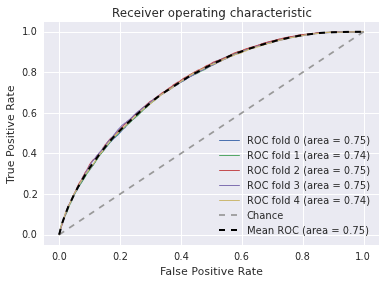

In [13]:
#Train AdaBoost on 44 most reliable features and plot ROC
#Training AUC is 0.73
_, AB_clf = mfit.fit_plot_ROC(X_train[reliable_feat.index[0:43]], y_train, AB_clf, cv)

/Users/jared/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


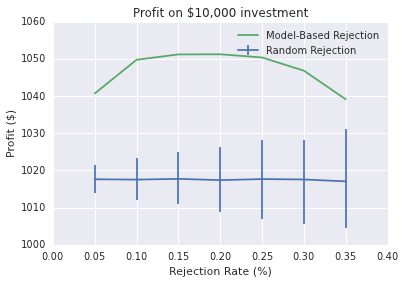

In [14]:
#Look at performance in monetary terms for validation set
probas_ = AB_clf.predict_proba(X_val[reliable_feat.index[0:43]])
prob_default = pd.Series(data = probas_[:,1], index=X_val[reliable_feat.index[0:43]].index)
pred_ROI = ROI.loc[X_val[reliable_feat.index[0:43]].index]
pred_ROI['default'] = y_val
b = 10000
p_rej = np.arange(0.05, 0.4, 0.05)
val_frame = lr.model_perf_dollars(pred_ROI, prob_default, p_rej, 'default', 'roi', 0)

In [15]:
val_frame

,reject,random,random_hi_ci,random_lo_ci,perfect
0.05,1040.662169,1017.615202,1021.384948,1013.941201,1245.888302
0.10,1049.736929,1017.524631,1023.298488,1012.176584,1245.888302
0.15,1051.179317,1017.723691,1025.070706,1011.015449,1245.888302
0.20,1051.216406,1017.387829,1026.248246,1008.897986,1245.888302
0.25,1050.357895,1017.667779,1028.195305,1006.934584,1245.888302
0.30,1046.800000,1017.563276,1028.141033,1005.666458,1245.888302
0.35,1039.111111,1017.053565,1031.013889,1004.600000,1245.888302


In [16]:
#Test adding features one at a time for AdaBoost with a Decision Stump, excluding interest rate and loan amount
#n_estimators = 100, AUC: 0.70
clf = DecisionTreeClassifier(max_depth = 1, class_weight = {0: (1.0 - 0.1841), 1: 0.1841})
AB_clf = AdaBoostClassifier(base_estimator=clf, n_estimators=100, random_state=42)
AB_feat_df = mfit.add_feature_auc(X_train.drop(['int_rate', 'loan_amnt'], axis = 1),
                                  y_train, X_val.drop(['int_rate', 'loan_amnt'], axis = 1), y_val, AB_clf, cv, 44)

AB_feat_df

,cv_auc,cv_std,train_auc,val_auc
1,0.580282,0.003569,0.583217,0.580204
2,0.599840,0.003159,0.604129,0.597321
3,0.611419,0.001604,0.615511,0.613744
4,0.627699,0.001267,0.632219,0.631711
5,0.628993,0.001635,0.633550,0.633042
6,0.628975,0.001424,0.633509,0.632405
7,0.630669,0.000925,0.635667,0.633641
8,0.635749,0.001093,0.640395,0.640860
9,0.695985,0.001173,0.699508,0.699733
10,0.696913,0.000541,0.699918,0.699266


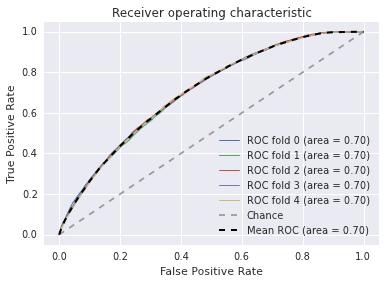

In [17]:
#Train AdaBoost on 44 most reliable features (exclude interest and loan amount) and plot ROC
#Training AUC is 0.7
_, AB_clf = mfit.fit_plot_ROC(X_train[reliable_feat_no_amnt_intr.index[0:43]], y_train, AB_clf, cv)

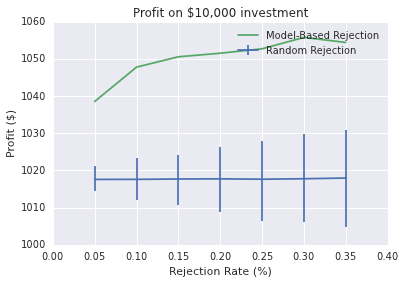

In [18]:
#Look at performance in monetary terms for validation set, excluding interest and loan amount
probas_ = AB_clf.predict_proba(X_val[reliable_feat_no_amnt_intr.index[0:43]])
prob_default = pd.Series(data = probas_[:,1], index=X_val[reliable_feat_no_amnt_intr.index[0:43]].index)
pred_ROI = ROI.loc[X_val[reliable_feat_no_amnt_intr.index[0:43]].index]
pred_ROI['default'] = y_val
b = 10000
p_rej = np.arange(0.05, 0.4, 0.05)
val_frame = lr.model_perf_dollars(pred_ROI, prob_default, p_rej, 'default', 'roi', 0)

In [19]:
val_frame

,reject,random,random_hi_ci,random_lo_ci,perfect
0.05,1038.528363,1017.575374,1021.236245,1014.446094,1245.888302
0.10,1047.758333,1017.594202,1023.323667,1012.013401,1245.888302
0.15,1050.540678,1017.686370,1024.028295,1010.748558,1245.888302
0.20,1051.500000,1017.730164,1026.253333,1008.900000,1245.888302
0.25,1052.685992,1017.628122,1027.976667,1006.513011,1245.888302
0.30,1055.748433,1017.758761,1029.913751,1006.012945,1245.888302
0.35,1054.398133,1017.944039,1030.772234,1004.906884,1245.888302


For the AdaBoost classifier, I tested performance out to 44 features in order of reliability for collections of 10, 100, and 200 Decision Stump estimators. After 100 estimators, the performance is flat. Including all features led to peak performance. For this classifier, the area under the ROC curve is 0.75. If this classifier is used to reject the top 15% of loans with respect to riskiness, the return on a $10,000 investment would be $1051.17. This return reliable is above the chance return. Perfect rejection (i.e., only loans that default) would yield a return of \$1245.88.

Excluding the interest rate and loan amount, the area under the ROC curve drops to 0.70. In monetary terms, the return on a $10,000 investment would be $1050.54 if the top 15 percent of risky loans are rejected. This is still better performance than chance. Performance does increase as rejection rates increase as with the previous decision tree based classifiers that exculded interest rate and loan amount. This behavior seems to suggest that the model is classifying less profitable loans as having a higher default risk.

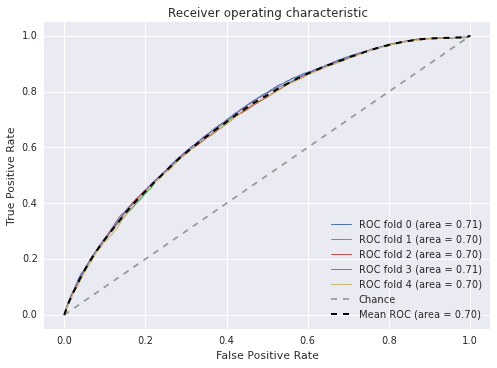

In [8]:
clf = DecisionTreeClassifier(max_depth = 3, class_weight = {0: (1.0 - 0.1841), 1: 0.1841})
AB_clf = AdaBoostClassifier(base_estimator=clf, n_estimators=100, random_state=42)
_, AB_clf = mfit.fit_plot_ROC(X_train[reliable_feat_no_amnt_intr.index[0:43]], y_train, AB_clf, cv)

/Users/jared/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


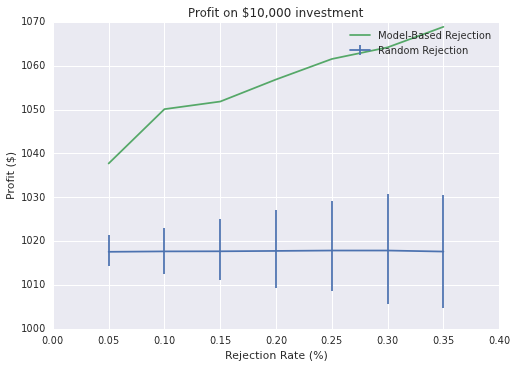

In [9]:
#Look at performance in monetary terms for validation set, excluding interest and loan amount
probas_ = AB_clf.predict_proba(X_val[reliable_feat_no_amnt_intr.index[0:43]])
prob_default = pd.Series(data = probas_[:,1], index=X_val[reliable_feat_no_amnt_intr.index[0:43]].index)
pred_ROI = ROI.loc[X_val[reliable_feat_no_amnt_intr.index[0:43]].index]
pred_ROI['default'] = y_val
b = 10000
p_rej = np.arange(0.05, 0.4, 0.05)
val_frame = lr.model_perf_dollars(pred_ROI, prob_default, p_rej, 'default', 'roi', 0)

In [10]:
val_frame

,reject,random,random_hi_ci,random_lo_ci,perfect
0.05,1037.704214,1017.559884,1021.346667,1014.299829,1245.888302
0.10,1050.100000,1017.657400,1022.883814,1012.600000,1245.888302
0.15,1051.834618,1017.678586,1024.983018,1011.058729,1245.888302
0.20,1056.867036,1017.761912,1027.055241,1009.218789,1245.888302
0.25,1061.540000,1017.853146,1029.055000,1008.571249,1245.888302
0.30,1064.191667,1017.854464,1030.744245,1005.622869,1245.888302
0.35,1068.875000,1017.617533,1030.497736,1004.665000,1245.888302


In [5]:
DT_entropy_clf = DecisionTreeClassifier(max_depth = 3, class_weight = {0: (1.0 - 0.1841), 1: 0.1841},
                                        criterion = 'entropy')
DT_gini_clf = DecisionTreeClassifier(max_depth = 3, class_weight = {0: (1.0 - 0.1841), 1: 0.1841},
                                        criterion = 'gini')

clfs = [RandomForestClassifier(n_estimators=100, 
                               min_samples_leaf = 5, 
                               class_weight = {0: (1.0 - 0.1841), 1: 0.1841},
                               n_jobs = -1,
                               criterion = 'gini'),
        RandomForestClassifier(n_estimators=100, 
                               min_samples_leaf = 5, 
                               class_weight = {0: (1.0 - 0.1841), 1: 0.1841},
                               n_jobs = -1,
                               criterion = 'entropy'),
       ExtraTreesClassifier(n_estimators=100, 
                               min_samples_leaf = 5, 
                               class_weight = {0: (1.0 - 0.1841), 1: 0.1841},
                               n_jobs = -1,
                               criterion = 'gini'),
        ExtraTreesClassifier(n_estimators=100, 
                               min_samples_leaf = 5, 
                               class_weight = {0: (1.0 - 0.1841), 1: 0.1841},
                               n_jobs = -1,
                               criterion = 'entropy'),
       GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=50),
       AdaBoostClassifier(base_estimator=DT_entropy_clf, n_estimators=100, random_state=42),
       AdaBoostClassifier(base_estimator=DT_gini_clf, n_estimators=100, random_state=42)]
clf_2 = LogisticRegression(penalty='l2', C=1, class_weight = {0: (1.0 - 0.1841), 1: 0.1841})
clfs, clf_2 = mfit.fit_stacked_clf(clfs, clf_2, cv, X_train[reliable_feat_no_amnt_intr[0:43].index], y_train)

Training classifiers with cross-validation
0 RandomForestClassifier(bootstrap=True, class_weight={0: 0.8159, 1: 0.1841},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
1 RandomForestClassifier(bootstrap=True, class_weight={0: 0.8159, 1: 0.1841},
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
2 ExtraTreesClassifier(bootstrap=False, class_weight={0: 0.8159, 1: 0.1841},
           criterion='gini', max_depth=None, max_

In [11]:
from sklearn.externals import joblib
joblib.dump(clf_2, 'clf_stack_2.pkl')
joblib.dump(clfs[0], 'clf0_stack_1.pkl')
joblib.dump(clfs[1], 'clf1_stack_1.pkl')
joblib.dump(clfs[2], 'clf2_stack_1.pkl')
joblib.dump(clfs[3], 'clf3_stack_1.pkl')
joblib.dump(clfs[4], 'clf4_stack_1.pkl')
joblib.dump(clfs[5], 'clf5_stack_1.pkl')
joblib.dump(clfs[6], 'clf6_stack_1.pkl')

['clf6_stack_1.pkl',
 'clf6_stack_1.pkl_01.npy',
 'clf6_stack_1.pkl_02.npy',
 'clf6_stack_1.pkl_03.npy',
 'clf6_stack_1.pkl_04.npy',
 'clf6_stack_1.pkl_05.npy',
 'clf6_stack_1.pkl_06.npy',
 'clf6_stack_1.pkl_07.npy',
 'clf6_stack_1.pkl_08.npy',
 'clf6_stack_1.pkl_09.npy',
 'clf6_stack_1.pkl_10.npy',
 'clf6_stack_1.pkl_11.npy',
 'clf6_stack_1.pkl_12.npy',
 'clf6_stack_1.pkl_13.npy',
 'clf6_stack_1.pkl_14.npy',
 'clf6_stack_1.pkl_15.npy',
 'clf6_stack_1.pkl_16.npy',
 'clf6_stack_1.pkl_17.npy',
 'clf6_stack_1.pkl_18.npy',
 'clf6_stack_1.pkl_19.npy',
 'clf6_stack_1.pkl_20.npy',
 'clf6_stack_1.pkl_21.npy',
 'clf6_stack_1.pkl_22.npy',
 'clf6_stack_1.pkl_23.npy',
 'clf6_stack_1.pkl_24.npy',
 'clf6_stack_1.pkl_25.npy',
 'clf6_stack_1.pkl_26.npy',
 'clf6_stack_1.pkl_27.npy',
 'clf6_stack_1.pkl_28.npy',
 'clf6_stack_1.pkl_29.npy',
 'clf6_stack_1.pkl_30.npy',
 'clf6_stack_1.pkl_31.npy',
 'clf6_stack_1.pkl_32.npy',
 'clf6_stack_1.pkl_33.npy',
 'clf6_stack_1.pkl_34.npy',
 'clf6_stack_1.pkl_35.npy',

Estimating probabilities for test set
Classifier 0
Classifier 1
Classifier 2
Classifier 3
Classifier 4
Classifier 5
Classifier 6


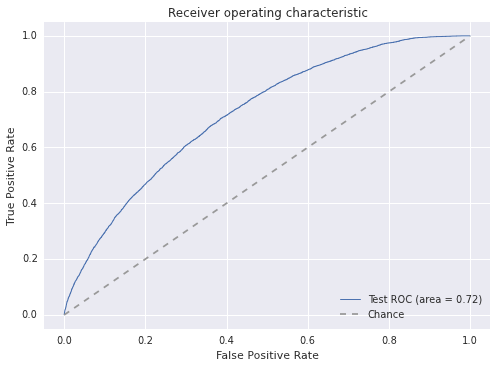

In [6]:
probas_ = mfit.stacked_clf_predict(clfs, clf_2, X_val[reliable_feat_no_amnt_intr[0:43].index], y_val)

/Users/jared/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


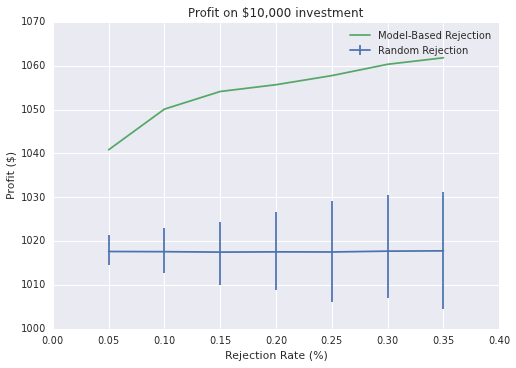

In [8]:
prob_default = pd.Series(data = probas_[:,1], index=X_val[reliable_feat_no_amnt_intr[0:43].index].index)
prob_default
pred_ROI = ROI.loc[X_val[reliable_feat_no_amnt_intr.index[0:43]].index]
pred_ROI['default'] = y_val
b = 10000
p_rej = np.arange(0.05, 0.4, 0.05)

val_frame = lr.model_perf_dollars(pred_ROI, prob_default, p_rej, 'default', 'roi', 0)

In [9]:
val_frame

,reject,random,random_hi_ci,random_lo_ci,perfect
0.05,1040.827083,1017.631981,1021.309578,1014.446094,1245.888302
0.10,1050.106667,1017.589576,1022.883814,1012.620690,1245.888302
0.15,1054.128333,1017.491935,1024.470000,1010.045127,1245.888302
0.20,1055.674286,1017.548114,1026.595208,1008.819444,1245.888302
0.25,1057.750000,1017.521563,1029.187500,1006.182609,1245.888302
0.30,1060.331649,1017.711835,1030.628530,1006.950302,1245.888302
0.35,1061.815261,1017.780226,1031.141667,1004.483333,1245.888302


In [10]:
clf_2.coef_

array([[ 1.80413361,  2.74357769,  1.2465492 ,  1.54664945,  4.64190679,
         1.07967244,  0.91265859]])